<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-Likhitha/Bias_Practice_2_md.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import resample
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
np.random.seed(101)



In [2]:
n = 1500
genders = ["Male", "Female", "Non-binary"]
school_types = ["Public", "Private", "International"]
income_levels = ["Low", "Medium", "High"]

data = pd.DataFrame({
    "Applicant_ID": range(1, n+1),
    "Gender": np.random.choice(genders, n, p=[0.45, 0.5, 0.05]),
    "School_Type": np.random.choice(school_types, n, p=[0.5, 0.35, 0.15]),
    "Income_Level": np.random.choice(income_levels, n, p=[0.4, 0.4, 0.2]),
    "GPA": np.round(np.random.uniform(2.0, 4.0, n), 2),
    "Extra_Curricular_Score": np.random.randint(0, 100, n)
})

# Introduce bias: Private & High income students slightly more likely to get scholarships
data["Scholarship_Awarded"] = np.where(
    ((data["School_Type"] == "Private") & (data["GPA"] > 3.5)) |
    ((data["Income_Level"] == "High") & (data["Extra_Curricular_Score"] > 70)),
    np.random.choice([1, 0], n, p=[0.75, 0.25]),
    np.random.choice([1, 0], n, p=[0.45, 0.55])
)

print("Dataset shape:", data.shape)
display(data.head())


Dataset shape: (1500, 7)


,Applicant_ID,Gender,School_Type,Income_Level,GPA,Extra_Curricular_Score,Scholarship_Awarded
0,1,Female,International,Low,3.09,68,1
1,2,Female,Public,Medium,3.90,3,0
2,3,Male,Public,Medium,2.45,8,1
3,4,Male,Public,Medium,3.94,1,1
4,5,Female,Private,Medium,3.43,88,0



=== 1) Group representation ===
Gender distribution:
 Gender
Female        0.497
Male          0.455
Non-binary    0.048
Name: proportion, dtype: float64

School_Type distribution:
 School_Type
Public           0.501
Private          0.365
International    0.135
Name: proportion, dtype: float64

Income_Level distribution:
 Income_Level
Low       0.391
Medium    0.389
High      0.220
Name: proportion, dtype: float64

=== Scholarship rates by group ===
By Gender:
 Gender
Female        0.529
Male          0.463
Non-binary    0.417
Name: Scholarship_Awarded, dtype: float64
By School_Type:
 School_Type
International    0.460
Private          0.521
Public           0.482
Name: Scholarship_Awarded, dtype: float64
By Income_Level:
 Income_Level
High      0.573
Low       0.483
Medium    0.459
Name: Scholarship_Awarded, dtype: float64

Chi-square p-values (Scholarship_Awarded vs):
Gender p = 0.018089580965788745
School_Type p = 0.23004260304768603
Income_Level p = 0.003439311863781505


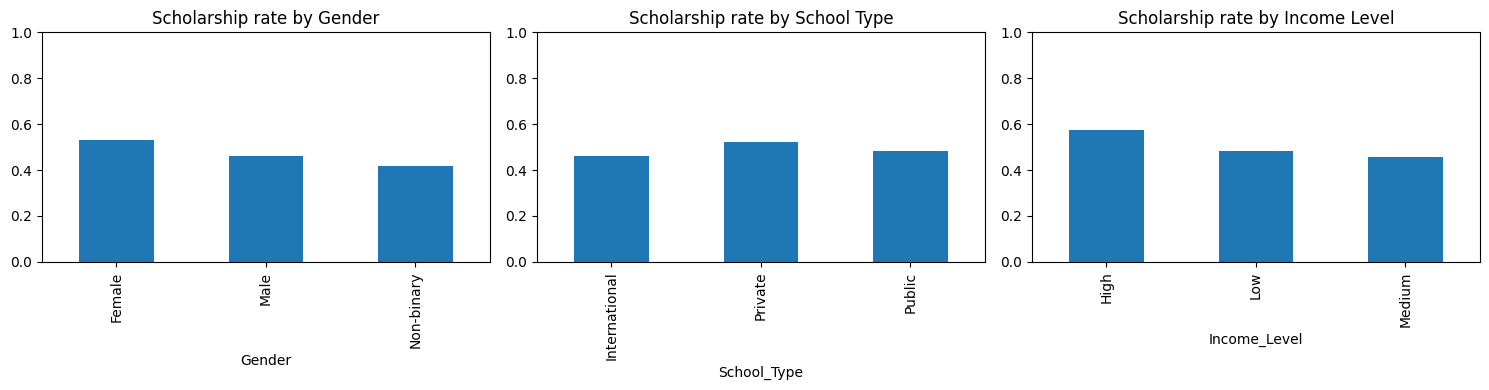

In [3]:
print("\n=== 1) Group representation ===")
print("Gender distribution:\n", data['Gender'].value_counts(normalize=True).round(3))
print("\nSchool_Type distribution:\n", data['School_Type'].value_counts(normalize=True).round(3))
print("\nIncome_Level distribution:\n", data['Income_Level'].value_counts(normalize=True).round(3))

print("\n=== Scholarship rates by group ===")
print("By Gender:\n", data.groupby('Gender')['Scholarship_Awarded'].mean().round(3))
print("By School_Type:\n", data.groupby('School_Type')['Scholarship_Awarded'].mean().round(3))
print("By Income_Level:\n", data.groupby('Income_Level')['Scholarship_Awarded'].mean().round(3))

# Chi-square tests to check dependence
def chi2_test(cat_col):
    ct = pd.crosstab(data[cat_col], data['Scholarship_Awarded'])
    chi2, p, dof, exp = chi2_contingency(ct)
    return p

print("\nChi-square p-values (Scholarship_Awarded vs):")
print("Gender p =", chi2_test('Gender'))
print("School_Type p =", chi2_test('School_Type'))
print("Income_Level p =", chi2_test('Income_Level'))

# Visualization: award rates by group
fig, axs = plt.subplots(1,3, figsize=(15,4))
data.groupby('Gender')['Scholarship_Awarded'].mean().plot(kind='bar', ax=axs[0], title='Scholarship rate by Gender', ylim=(0,1))
data.groupby('School_Type')['Scholarship_Awarded'].mean().plot(kind='bar', ax=axs[1], title='Scholarship rate by School Type', ylim=(0,1))
data.groupby('Income_Level')['Scholarship_Awarded'].mean().plot(kind='bar', ax=axs[2], title='Scholarship rate by Income Level', ylim=(0,1))
plt.tight_layout()
plt.show()

In [4]:
def prepare_X(df, drop_sensitive=False):
    X = df[['GPA','Extra_Curricular_Score','Gender','School_Type','Income_Level']].copy()
    if drop_sensitive:
        X = X.drop(columns=['Gender','School_Type','Income_Level'])
    X = pd.get_dummies(X, drop_first=True)
    return X

X = prepare_X(data, drop_sensitive=False)
y = data['Scholarship_Awarded']

# Train/test split (stratify to keep label distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

model = LogisticRegression(solver='liblinear', max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nBaseline accuracy:", round(accuracy_score(y_test, y_pred),3))
try:
    print("Baseline AUC:", round(roc_auc_score(y_test, y_prob),3))
except:
    pass

# Helper to compute per-group metrics
def group_metrics(y_true, y_pred, group_series):
    df = pd.DataFrame({'y_true': y_true.values, 'y_pred': y_pred, 'group': group_series.values})
    rows=[]
    for g in df['group'].unique():
        s = df[df['group']==g]
        tn, fp, fn, tp = confusion_matrix(s['y_true'], s['y_pred'], labels=[0,1]).ravel()
        acc = (tp+tn)/(tp+tn+fp+fn) if (tp+tn+fp+fn)>0 else np.nan
        tpr = tp/(tp+fn) if (tp+fn)>0 else 0
        fpr = fp/(fp+tn) if (fp+tn)>0 else 0
        pos_rate = s['y_pred'].mean()
        rows.append((g, len(s), round(acc,3), round(tpr,3), round(fpr,3), round(pos_rate,3)))
    return pd.DataFrame(rows, columns=['group','count','accuracy','TPR','FPR','pred_positive_rate']).set_index('group')

# Map test indices back to original data to fetch sensitive attributes
group_gender_test = data.loc[y_test.index, 'Gender']
group_school_test = data.loc[y_test.index, 'School_Type']
group_income_test = data.loc[y_test.index, 'Income_Level']

print("\nPer-group metrics (Gender) baseline:")
display(group_metrics(y_test, y_pred, group_gender_test))

print("\nPer-group metrics (School_Type) baseline:")
display(group_metrics(y_test, y_pred, group_school_test))

print("\nPer-group metrics (Income_Level) baseline:")
display(group_metrics(y_test, y_pred, group_income_test))



Baseline accuracy: 0.564
Baseline AUC: 0.546

Per-group metrics (Gender) baseline:


,count,accuracy,TPR,FPR,pred_positive_rate
group,,,,,
Female,216,0.565,0.723,0.606,0.667
Male,210,0.548,0.248,0.174,0.210
Non-binary,24,0.708,0.333,0.067,0.167



Per-group metrics (School_Type) baseline:


,count,accuracy,TPR,FPR,pred_positive_rate
group,,,,,
Private,166,0.596,0.805,0.607,0.705
International,60,0.517,0.478,0.459,0.467
Public,224,0.554,0.274,0.140,0.210



Per-group metrics (Income_Level) baseline:


,count,accuracy,TPR,FPR,pred_positive_rate
group,,,,,
Medium,189,0.577,0.420,0.306,0.354
Low,170,0.535,0.326,0.250,0.288
High,91,0.593,0.855,0.806,0.835


In [5]:
def demographic_parity_diff(y_true, y_pred, group):
    df = pd.DataFrame({'y_pred': y_pred, 'group': group.values})
    rates = df.groupby('group')['y_pred'].mean()
    return float(rates.max() - rates.min())

def equal_opportunity_diff(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true.values, 'y_pred': y_pred, 'group': group.values})
    tpr = {}
    for g in df['group'].unique():
        s = df[df['group']==g]
        tp = ((s['y_true']==1) & (s['y_pred']==1)).sum()
        fn = ((s['y_true']==1) & (s['y_pred']==0)).sum()
        tpr[g] = tp/(tp+fn) if (tp+fn)>0 else 0
    vals = list(tpr.values())
    return float(max(vals)-min(vals))

def disparate_impact_ratio(y_true, y_pred, group):
    df = pd.DataFrame({'y_pred': y_pred, 'group': group.values})
    rates = df.groupby('group')['y_pred'].mean().sort_values()
    if len(rates) < 2 or rates.iloc[-1] == 0:
        return np.nan
    return float(rates.iloc[0] / rates.iloc[-1])

print("\nBaseline fairness metrics:")
print("School_Type - Demographic parity diff:", round(demographic_parity_diff(y_test, y_pred, group_school_test),3))
print("School_Type - Equal opportunity diff:", round(equal_opportunity_diff(y_test, y_pred, group_school_test),3))
print("School_Type - Disparate impact ratio:", round(disparate_impact_ratio(y_test, y_pred, group_school_test),3))



Baseline fairness metrics:
School_Type - Demographic parity diff: 0.495
School_Type - Equal opportunity diff: 0.531
School_Type - Disparate impact ratio: 0.298


In [6]:
print("\n=== Mitigation: Upsample to balance School_Type (pre-processing) ===")
data_reset = data.reset_index(drop=True)
counts = data_reset['School_Type'].value_counts()
max_count = counts.max()
dfs=[]
for st, grp in data_reset.groupby('School_Type'):
    if len(grp) < max_count:
        up = resample(grp, replace=True, n_samples=max_count, random_state=42)
        dfs.append(up)
    else:
        dfs.append(grp)
data_balanced = pd.concat(dfs).reset_index(drop=True)
print("Balanced School_Type counts:\n", data_balanced['School_Type'].value_counts())

# Prepare features and retrain on balanced data
Xb = prepare_X(data_balanced, drop_sensitive=False)
yb = data_balanced['Scholarship_Awarded']
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.30, random_state=42, stratify=yb)

model_bal = LogisticRegression(solver='liblinear', max_iter=200)
model_bal.fit(Xb_train, yb_train)
yb_pred = model_bal.predict(Xb_test)

# Map group attributes for balanced test
gb_school_test = data_balanced.loc[yb_test.index, 'School_Type']
gb_gender_test = data_balanced.loc[yb_test.index, 'Gender']
gb_income_test = data_balanced.loc[yb_test.index, 'Income_Level']

print("\nBalanced model accuracy:", round(accuracy_score(yb_test, yb_pred),3))
print("\nPer-group metrics (School_Type) after balancing:")
display(group_metrics(yb_test, yb_pred, gb_school_test))

print("\nFairness metrics (School_Type) after balancing:")
print("Demographic parity diff:", round(demographic_parity_diff(yb_test, yb_pred, gb_school_test),3))
print("Equal opportunity diff:", round(equal_opportunity_diff(yb_test, yb_pred, gb_school_test),3))
print("Disparate impact ratio:", round(disparate_impact_ratio(yb_test, yb_pred, gb_school_test),3))



=== Mitigation: Upsample to balance School_Type (pre-processing) ===
Balanced School_Type counts:
 School_Type
International    751
Private          751
Public           751
Name: count, dtype: int64

Balanced model accuracy: 0.556

Per-group metrics (School_Type) after balancing:


,count,accuracy,TPR,FPR,pred_positive_rate
group,,,,,
Public,246,0.549,0.466,0.377,0.419
Private,215,0.605,0.851,0.713,0.791
International,215,0.516,0.275,0.265,0.270



Fairness metrics (School_Type) after balancing:
Demographic parity diff: 0.521
Equal opportunity diff: 0.577
Disparate impact ratio: 0.341


In [7]:
print("\n=== Mitigation: Drop (mask) sensitive features and retrain ===")
Xd = prepare_X(data, drop_sensitive=True)
yd = data['Scholarship_Awarded']
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.30, random_state=42, stratify=yd)
model_drop = LogisticRegression(solver='liblinear', max_iter=200)
model_drop.fit(Xd_train, yd_train)
yd_pred = model_drop.predict(Xd_test)

group_school_test_orig = data.loc[yd_test.index, 'School_Type']
print("Accuracy (drop sensitive):", round(accuracy_score(yd_test, yd_pred),3))
print("\nPer-group parity diff (School_Type) after dropping sensitive features:",
      round(demographic_parity_diff(yd_test, yd_pred, group_school_test_orig),3))
print("\nPer-group metrics (School_Type) after dropping sensitive features:")
display(group_metrics(yd_test, yd_pred, group_school_test_orig))


=== Mitigation: Drop (mask) sensitive features and retrain ===
Accuracy (drop sensitive): 0.524

Per-group parity diff (School_Type) after dropping sensitive features: 0.11

Per-group metrics (School_Type) after dropping sensitive features:


,count,accuracy,TPR,FPR,pred_positive_rate
group,,,,,
Private,166,0.602,0.512,0.310,0.410
International,60,0.467,0.478,0.541,0.517
Public,224,0.482,0.393,0.421,0.406


In [9]:
print("\n" + "="*60)
print("SUMMARY & RECOMMENDATIONS")
print("- Baseline accuracy:", round(accuracy_score(y_test, y_pred),3))
print("- Baseline School_Type demographic parity diff:", round(demographic_parity_diff(y_test, y_pred, group_school_test),3))
print("- After pre-processing (balance School_Type): accuracy:", round(accuracy_score(yb_test, yb_pred),3))
print("- After pre-processing parity diff:", round(demographic_parity_diff(yb_test, yb_pred, gb_school_test),3))
print("\nRecommendations:")
print("1) Use pre-processing (resampling or reweighting) to reduce distributional bias across School_Type/Income.")
print("2) Combine pre-processing with in-processing techniques (fairness-aware training) and monitoring.")
print("3) Consider removing or masking sensitive attributes when appropriate—but monitor accuracy/fairness trade-offs.")
print("4) Add per-group metrics to CI/CD gates (e.g., fail if parity diff > 0.1).")
print("5) Produce a transparency report and collect stakeholder feedback before deployment.")
print("="*60)


SUMMARY & RECOMMENDATIONS
- Baseline accuracy: 0.564
- Baseline School_Type demographic parity diff: 0.495
- After pre-processing (balance School_Type): accuracy: 0.556
- After pre-processing parity diff: 0.521

Recommendations:
1) Use pre-processing (resampling or reweighting) to reduce distributional bias across School_Type/Income.
2) Combine pre-processing with in-processing techniques (fairness-aware training) and monitoring.
3) Consider removing or masking sensitive attributes when appropriate—but monitor accuracy/fairness trade-offs.
4) Add per-group metrics to CI/CD gates (e.g., fail if parity diff > 0.1).
5) Produce a transparency report and collect stakeholder feedback before deployment.
